In [0]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Direct to the correct directory
import os
os.chdir("drive/My Drive/SEPSIS")

In [0]:
# Check the files
!ls

 10		     labelsB1.txt   __pycache__         X_train.txt
'#1_GRU_Model.h5'    labelsB.txt    training	        y_test.txt
'#1_LSTM_Model.h5'   labels.txt     trainingdataX.txt   y_train.txt
 dataB1.txt	     other	    trainingdataY.txt
 dataB.txt	     padded_X.txt   training_setB
 data.txt	     padded_Y.txt   X_test.txt


In [0]:
# Import the necessary modules
import tensorflow as tf
import keras

Using TensorFlow backend.


In [0]:
# Load the dataset including the labels
import pickle

with open("X_train.txt", "rb") as fp:   # Unpickling
  X = pickle.load(fp)

with open("y_train.txt", "rb") as fp:   # Unpickling
  y = pickle.load(fp)

In [0]:
# Split the x and Y sets into train and test splits

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1111111)

In [0]:
# Check sizes for train and test

print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

8849
8849
1107
1107


In [0]:
# Import packages
# Adapt the original Cross Entropy Loss function by adding weights to "no sepsis" label

import numpy as np 
import math

def keras_custom_loss_function(y_true, y_pred):
  custom_loss = -y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred) * 0.7
  return custom_loss

In [0]:
# Create the architecture of the model including all the parameters
# Set the optimizer, loss function and metric

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(336,40)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(400, dropout=0.2, recurrent_dropout=0.5, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(400, dropout=0.2, recurrent_dropout=0.5, return_sequences=True),   
    tf.keras.layers.BatchNormalization(),     
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.BatchNormalization(),      
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.BatchNormalization(),      
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),      
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.BatchNormalization(),      
    tf.keras.layers.Dense(2,  activation='softmax'),   
  ])

  opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)


  model.compile(optimizer=opt,
                loss=keras_custom_loss_function,
                metrics=[tf.keras.metrics.AUC()])
  return model

In [0]:
# Compile the model and get a summary of it

model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 336, 40)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 336, 40)           160       
_________________________________________________________________
lstm (LSTM)                  (None, 336, 400)          705600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 336, 400)          1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 336, 400)          1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 336, 400)          1600      
_________________________________________________________________
dense (Dense)                (None, 336, 250)          1

In [0]:
# Train the model for 10 epochs with a batchsize of 64

original = model.fit(X_train,y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
139/139 [==============================] - 424s 3s/step - loss: 0.0550 - auc: 0.5326 - val_loss: 0.0833 - val_auc: 0.0496
Epoch 2/10
139/139 [==============================] - 384s 3s/step - loss: 0.0423 - auc: 0.6050 - val_loss: 0.0652 - val_auc: 0.2615
Epoch 3/10
139/139 [==============================] - 380s 3s/step - loss: 0.0371 - auc: 0.6708 - val_loss: 0.0414 - val_auc: 0.5965
Epoch 4/10
139/139 [==============================] - 376s 3s/step - loss: 0.0324 - auc: 0.7376 - val_loss: 0.0278 - val_auc: 0.8441
Epoch 5/10
139/139 [==============================] - 373s 3s/step - loss: 0.0289 - auc: 0.8100 - val_loss: 0.0235 - val_auc: 0.9250
Epoch 6/10
139/139 [==============================] - 378s 3s/step - loss: 0.0252 - auc: 0.8759 - val_loss: 0.0226 - val_auc: 0.9363
Epoch 7/10
139/139 [==============================] - 382s 3s/step - loss: 0.0225 - auc: 0.9338 - val_loss: 0.0195 - val_auc: 0.9881
Epoch 8/10
139/139 [==============================] - 379s 3s/step - 

In [0]:
# Print necessary dictionary keys

history_dict = original.history
history_dict.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

In [0]:
# Make a function for plotting the AUC score and loss for train and validation set

import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

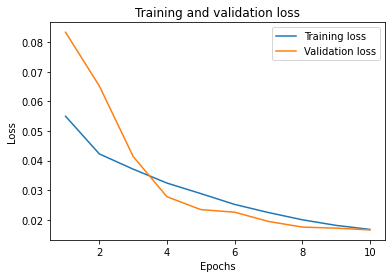

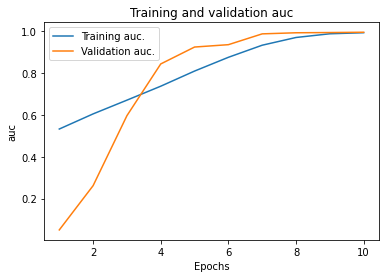

In [0]:
# Plot AUC score and loss for train and validation set
auc = history_dict['auc']
val_auc = history_dict['val_auc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[auc, val_auc],
             label_list=['Training auc.', 'Validation auc.'],
             title='Training and validation auc',
             ylabel='auc')

In [0]:
# Save the weights of the model

from numpy import loadtxt

# serialize weights to HDF5
model.save("#2_LSTM_Model.h5")
print("Saved model to disk")

Saved model to disk
